In [9]:
### motivation of this notebook: predict rating is a classification problem. 
### By using mean sqared error, and output a single number, we treat it as a regression problem.
### This method for a classification problem is not natural.
### This notebook uses softmax and cross entropy to learn the probability of 5 rating class.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## load data

In [2]:
def load_data():
    age_desc = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
    occupation_desc = {
        0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin", 
        4: "college/grad student", 5: "customer service", 6: "doctor/health care", 
        7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
        12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
        17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer" }
    rating_data = pd.read_csv(
        "ml-1m/ratings.dat",
        sep="::",
        engine="python",
        encoding="latin-1",
        names=['userid', 'movieid', 'rating', 'timestamp'])
    user_data = pd.read_csv(
        "ml-1m/users.dat", 
        sep='::', 
        engine='python', 
        encoding='latin-1',
        names=['userid', 'gender', 'age', 'occupation', 'zipcode']
    )
    user_data['age_desc'] = user_data['age'].apply(lambda x: age_desc[x])
    user_data['occ_desc'] = user_data['occupation'].apply(lambda x: occupation_desc[x])
    movie_data = pd.read_csv(
        "ml-1m/movies.dat",
        sep='::', 
        engine='python', 
        encoding='latin-1',
        names=['movieid', 'title', 'genre']
    )
    dataset = pd.merge(pd.merge(rating_data, movie_data, how="left", on="movieid"), user_data, how="left", on="userid")
    adj_col = dataset['movieid']
    adj_col_uni = adj_col.sort_values().unique()
    adj_df = pd.DataFrame(adj_col_uni).reset_index().rename(columns = {0:'movieid','index':'adj_movieid'})
    dataset = pd.merge(adj_df,dataset,how="right", on="movieid")
    dataset['adj_userid'] = dataset['userid'] - 1
    return dataset

def train_valid_split(dataset):
    dataset = dataset.sample(frac=1, replace=False)
    n_split = int(len(dataset)*.7)
    trainset = dataset[:n_split]
    validset = dataset[n_split:]
    return trainset, validset

In [3]:
dataset = load_data()
trainset, validset = train_valid_split(dataset)

## create model

In [10]:
### Because we want to have a output of a vector with 5 values. We make movie embedding a tensor of [num_movies, dim, 5]
### This approach increases our parameter by 5 times. 
### In order to not introduce too much new parameter, we do the change on movie, since we have less movies than users in our dataset.
### The meaning of our embedding has changed from learning user features and movie features 
### to user features and movie rating features. 

In [7]:
def create_embeddings(num_users, num_movies, dim):
    user_embeddings = tf.get_variable(
        "theta",
        shape = [num_users, dim, 1],
        dtype = tf.float32,
        initializer = tf.truncated_normal_initializer(mean=0, stddev=.05)
    )
    movie_embeddings = tf.get_variable(
        "phi",
        shape = [num_movies, dim, 5],      
        dtype = tf.float32,
        initializer = tf.truncated_normal_initializer(mean=0, stddev=.05)
    )
    return user_embeddings, movie_embeddings

def create_dataset(user_ids, movie_ids, ratings):
    user_id_var = tf.get_variable("userid", initializer=user_ids, trainable=False)
    movie_id_var = tf.get_variable("movieid", initializer=movie_ids, trainable=False)
    ratings_var = tf.get_variable("ratings", initializer=np.asarray(ratings - 1, dtype=np.int32), trainable=False)
    return user_id_var, movie_id_var, ratings_var

def lookup_embeddings(user_embeddings, movie_embeddings, user_ids, movie_ids): 
    selected_user_embeddings = tf.gather(user_embeddings, user_ids)
    selected_movie_embeddings = tf.gather(movie_embeddings, movie_ids)
    return selected_user_embeddings, selected_movie_embeddings

def predict_logits(user_embeddings, movie_embeddings, user_ids, movie_ids):
    sel_usr_embs, sel_mov_embs = lookup_embeddings(user_embeddings, movie_embeddings, user_ids, movie_ids)
    selected_predictions = tf.reduce_sum(sel_usr_embs * sel_mov_embs, axis = 1)
    return selected_predictions

def predict_from_logits(logits):
    predictions = tf.nn.softmax(logits)
    return predictions

def predict(selected_user_embeddings, selected_movie_embeddings):
    logits = predict_logits(selected_user_embeddings, selected_movie_embeddings)
    predictions = predict_from_logits(logits)
    return predictions

def cross_entropy_loss(logits, ratings):
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=ratings, logits=logits))
    return loss

## hyperparameter

In [38]:
emb_dim = 8
learning_rate = 2500
epochs = 50
lam = 0.02

In [39]:
with tf.Graph().as_default():
    tf.set_random_seed(123)
    with tf.variable_scope("embeddings"):
        usr_embs, mov_embs = create_embeddings(dataset.adj_userid.max()+1, dataset.adj_movieid.max()+1, emb_dim)
    with tf.variable_scope("train_set"):
        train_data = trainset[["adj_userid", "adj_movieid", "rating"]].values.T
        train_usr_ids, train_mov_ids, train_ratings = create_dataset(*train_data)
    with tf.variable_scope("valid_set"):
        valid_data = validset[["adj_userid", "adj_movieid", "rating"]].values.T
        valid_usr_ids, valid_mov_ids, valid_ratings = create_dataset(*valid_data)
    with tf.variable_scope("training"):
        train_logits = predict_logits(usr_embs, mov_embs, train_usr_ids, train_mov_ids)
        train_preds = predict_from_logits(train_logits)
        train_loss = cross_entropy_loss(train_logits, train_ratings)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        train_usr_embs = optimizer.minimize(train_loss, var_list=[usr_embs])
        train_mov_embs = optimizer.minimize(train_loss, var_list=[mov_embs])
    with tf.variable_scope("validation"):
        valid_logits = predict_logits(usr_embs, mov_embs, valid_usr_ids, valid_mov_ids)
        valid_loss = cross_entropy_loss(valid_logits, valid_ratings)
        valid_preds = predict_from_logits(valid_logits)
    with tf.Session() as sess:
        train_loss_hist, valid_loss_hist = [], []
        sess.run(tf.global_variables_initializer())
        for i in range(epochs):
            sess.run(train_usr_embs)
            current_train_loss = sess.run([train_loss, train_mov_embs])[0]
            current_valid_loss = sess.run(valid_loss)
            train_loss_hist.append(current_train_loss)
            valid_loss_hist.append(current_valid_loss)
            print("%ith epoch: %f (train loss), %f (valid loss)"%(i+1, current_train_loss, current_valid_loss))
        final_user_embeddings, final_movie_embeddings = sess.run([usr_embs, mov_embs])
        final_valid_predictions = sess.run(valid_preds)

1th epoch: 1.609420 (train loss), 1.609440 (valid loss)
2th epoch: 1.609331 (train loss), 1.609444 (valid loss)
3th epoch: 1.609239 (train loss), 1.609440 (valid loss)
4th epoch: 1.609130 (train loss), 1.609423 (valid loss)
5th epoch: 1.608997 (train loss), 1.609375 (valid loss)
6th epoch: 1.608804 (train loss), 1.609256 (valid loss)
7th epoch: 1.608476 (train loss), 1.608947 (valid loss)
8th epoch: 1.607843 (train loss), 1.608197 (valid loss)
9th epoch: 1.606497 (train loss), 1.606383 (valid loss)
10th epoch: 1.603452 (train loss), 1.602028 (valid loss)
11th epoch: 1.596426 (train loss), 1.591966 (valid loss)
12th epoch: 1.580906 (train loss), 1.570634 (valid loss)
13th epoch: 1.550611 (train loss), 1.533265 (valid loss)
14th epoch: 1.504792 (train loss), 1.485649 (valid loss)
15th epoch: 1.455827 (train loss), 1.441828 (valid loss)
16th epoch: 1.415042 (train loss), 1.407891 (valid loss)
17th epoch: 1.383910 (train loss), 1.382869 (valid loss)
18th epoch: 1.360699 (train loss), 1.364

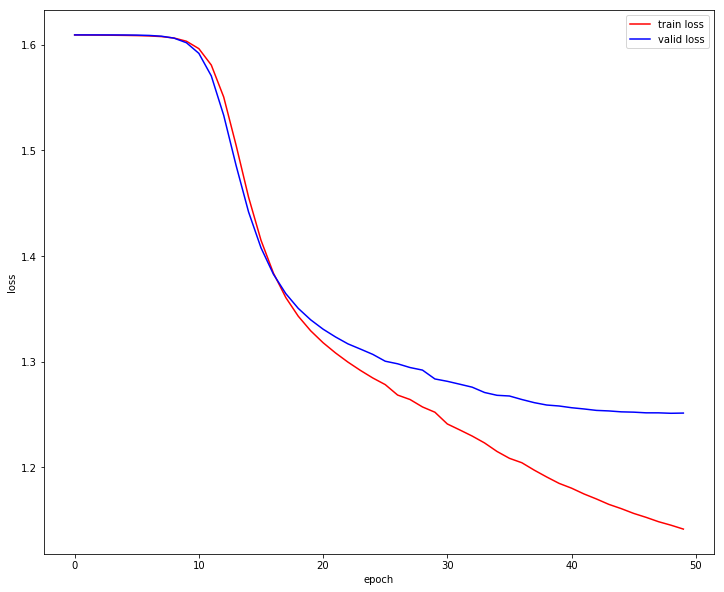

In [41]:
plt.figure(figsize=(12,10))
plt.plot(train_loss_hist, color="red", label="train loss")
plt.plot(valid_loss_hist, color="blue", label="valid loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [42]:
cor_predict = np.sum((final_valid_predictions.argmax(axis=1)+1)==validset['rating'].values)/len(validset)

In [43]:
print(cor_predict)

0.446886153908


In [52]:
results = validset[["gender", "age_desc","occ_desc", "title", "genre", "rating"]].copy()
results["rating 1"] = final_valid_predictions[:,0]
results["rating 2"] = final_valid_predictions[:,1]
results["rating 3"] = final_valid_predictions[:,2]
results["rating 4"] = final_valid_predictions[:,3]
results["rating 5"] = final_valid_predictions[:,4]
results.head(10)

,gender,age_desc,occ_desc,title,genre,rating,rating 1,rating 2,rating 3,rating 4,rating 5
431858,F,25-34,artist,Austin Powers: International Man of Mystery (1...,Comedy,5,0.060089,0.068795,0.249792,0.362282,0.259043
838854,M,45-49,self-employed,"End of the Affair, The (1999)",Drama,4,0.044739,0.123807,0.229246,0.471066,0.131142
472227,M,18-24,programmer,Starship Troopers (1997),Action|Adventure|Sci-Fi|War,3,0.364679,0.208149,0.204914,0.162565,0.059693
722735,F,25-34,academic/educator,Big Daddy (1999),Comedy,4,0.024424,0.082306,0.503652,0.355386,0.034231
128842,M,25-34,other or not specified,What's Love Got to Do with It? (1993),Drama,4,0.005140,0.019939,0.317069,0.636257,0.021595
640496,M,45-49,self-employed,Desperately Seeking Susan (1985),Comedy|Romance,4,0.098290,0.195854,0.413526,0.220636,0.071693
756037,M,35-44,executive/managerial,Vacation (1983),Comedy,3,0.007366,0.042529,0.205858,0.523238,0.221010
443088,F,25-34,technician/engineer,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,4,0.001989,0.017335,0.036079,0.900555,0.044043
964828,M,35-44,executive/managerial,"Conversation, The (1974)",Drama|Mystery,4,0.010955,0.013398,0.125774,0.458257,0.391616
440540,M,25-34,executive/managerial,My Best Friend's Wedding (1997),Comedy|Romance,4,0.011388,0.041044,0.335295,0.523580,0.088693
